In [1]:
import pandas as pd, geopandas as gpd, numpy as np, matplotlib.pyplot as plt
from os.path import join

pd.set_option('display.max_columns', 50)
plt.rcParams['pdf.fonttype'] = 'truetype'

## helpers

In [2]:
def decorate(xl, yl):
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.box(None)
    plt.legend(bbox_to_anchor=(1,.5), loc='center left', frameon=False)

## load data

In [3]:
turn = pd.read_csv(r"M:\NYSERDA_Ignition Grant 19041\03_GIS+ANALYSIS\01_DATA\station_vol_by_hour_final - station_vol_by_hour.csv")

In [4]:
turn.shape

(72634, 7)

In [5]:
turn.sample(10)

,station_id,GTFS Latitude,GTFS Longitude,wkdaynbr,timegroupstr,date,entries_diff
10441,69 StFlushing,40.746325,-73.896403,1,8am - 12pm,7/8/19,1523
32895,85 St - Forest PkwyJamaica,40.692435,-73.860010,3,4pm - 8pm,7/10/19,418
10986,Lexington Av/59 StAstoria,40.762660,-73.967258,1,4pm - 8pm,6/29/20,1465
64929,111 StJamaica,40.697418,-73.836345,4,12am - 4am,7/11/19,30
20977,8 AvSea Beach,40.635064,-74.011719,4,4pm - 8pm,7/4/19,785
25781,Tremont AvConcourse,40.850410,-73.905227,3,4pm - 8pm,7/8/20,609
66283,World Trade Center8th Av - Fulton St,40.712582,-74.009781,6,12am - 4am,6/27/20,20
53823,Tremont AvConcourse,40.850410,-73.905227,3,12am - 4am,7/1/20,124
21926,Essex StJamaica,40.718315,-73.987437,3,12am - 4am,7/10/19,744
15823,Kosciuszko StJamaica,40.693342,-73.928814,6,12pm - 4pm,7/6/19,1057


## prep data

In [6]:
# Datetime format for sorting / time-series analysis
turn['dt'] = pd.to_datetime(turn.date)

In [7]:
# recode time group as int for sorting / time-series analysis

time_map = {
    '8pm - 12am':5,
    '12pm - 4pm':3,
    '4pm - 8pm':4,
    '8am - 12pm':2,
    '4am - 8am':1,
    '12am - 4am':0}

turn['timegroupnbr'] = turn.timegroupstr.map(time_map)

assert turn.timegroupnbr.isna().sum() == 0

## filter and dissagregate

In [8]:
stops = [
    'Jamaica Center - Parsons/ArcherQueens - Archer',
    'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer',
    'Sutphin BlvdQueens Blvd']

In [9]:
filt = turn.station_id.isin(stops) & ~turn.wkdaynbr.isin([5, 6])

group_cols = ['station_id', 'dt', 'timegroupnbr']
agg = {'entries_diff':'sum'}

df19 = turn[filt & turn.dt.dt.year.eq(2019)]\
    .groupby(group_cols).agg(agg).reset_index()
df20 = turn[filt & turn.dt.dt.year.eq(2020)]\
    .groupby(group_cols).agg(agg).reset_index()

df19.sample(5)

,station_id,dt,timegroupnbr,entries_diff
94,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2019-07-07,4,957
21,Jamaica Center - Parsons/ArcherQueens - Archer,2019-07-03,3,2350
62,Sutphin Blvd - Archer Av - JFK AirportQueens -...,2019-06-30,2,213
28,Jamaica Center - Parsons/ArcherQueens - Archer,2019-07-04,4,3169
50,Jamaica Center - Parsons/ArcherQueens - Archer,2019-07-10,2,4008


## ridership trend

### overall

In [10]:
f'Ridership is down {np.round((1 - df20.entries_diff.sum() / df19.entries_diff.sum()) * 100, 1)}% overall'

'Ridership is down 56.4% overall'

In [11]:
1 - \
df20.groupby('station_id').agg({'entries_diff':'sum'}).div(
    df19.groupby('station_id').agg({'entries_diff':'sum'}))\
    .round(2)

,entries_diff
station_id,
Jamaica Center - Parsons/ArcherQueens - Archer,0.31
Sutphin Blvd - Archer Av - JFK AirportQueens - Archer,0.68
Sutphin BlvdQueens Blvd,0.72


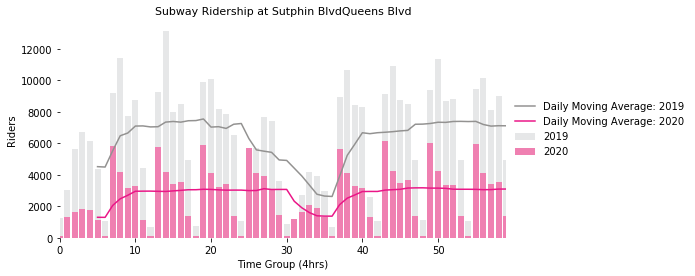

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Sutphin BlvdQueens Blvd'

a19 = df19.groupby(['dt', 'timegroupnbr']).agg({'entries_diff':'sum'}).reset_index().entries_diff
a20 = df20.groupby(['dt', 'timegroupnbr']).agg({'entries_diff':'sum'}).reset_index().entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2019')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2019')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', fontsize=11)

plt.show();

### sutphin blvd - queens blvd

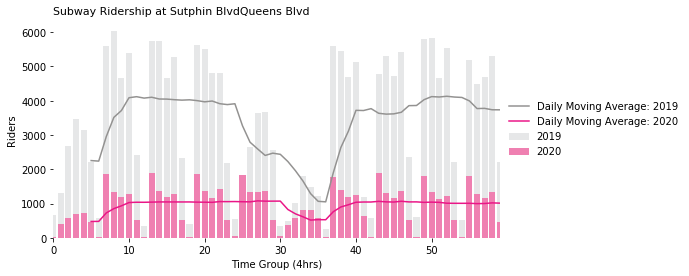

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Sutphin BlvdQueens Blvd'

a19 = df19[df19.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2019')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2019')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

### sutphin blvd - archer av - jfk - archer

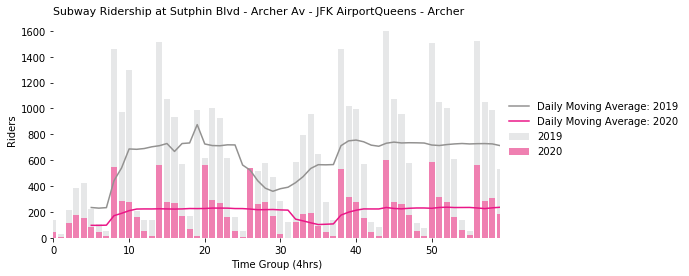

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer'

a19 = df19[df19.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2019')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2019')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

### jamaica center

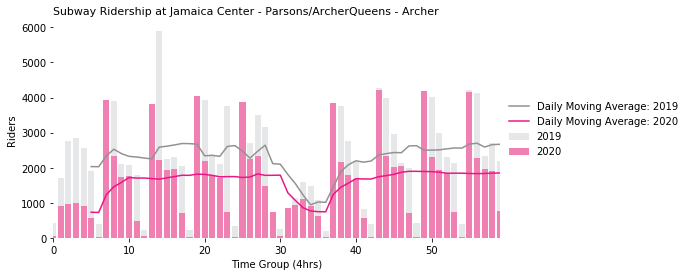

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

station = 'Jamaica Center - Parsons/ArcherQueens - Archer'

a19 = df19[df19.station_id.eq(station)].reset_index(drop=True).entries_diff
a20 = df20[df20.station_id.eq(station)].reset_index(drop=True).entries_diff

assert len(a19) == len(a20)

x = np.arange(len(a19))

ax.bar(x, height=a19.values, color='#e6e7e8', label='2019')
ax.bar(x, height=a20.values, color='#ef80b1', label='2020')

n = 6

a19.rolling(n).mean().plot(color='#939291', label='Daily Moving Average: 2019')
a20.rolling(n).mean().plot(color='#ea1687', label='Daily Moving Average: 2020')

decorate('Time Group (4hrs)', 'Riders')
plt.title(f'Subway Ridership at {station}', loc='left', fontsize=11)

plt.show();

## change in entries by time group

### overall

In [16]:
a19 = df19.copy()
a19.columns = [c + '_19' for c in a19.columns]

a20 = df20.copy()
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx

entries_share                              
                          min       max    median      mean
timegroupnbr_19                                            
0                    0.032401  0.482759  0.118843  0.177005
1                    0.000000  1.644096  0.336805  0.584239
2                    0.209898  1.442667  0.377348  0.472004
3                    0.199252  0.860177  0.305381  0.429311
4                    0.197492  0.955378  0.304846  0.434428
5                    0.137134  1.247039  0.293863  0.360122

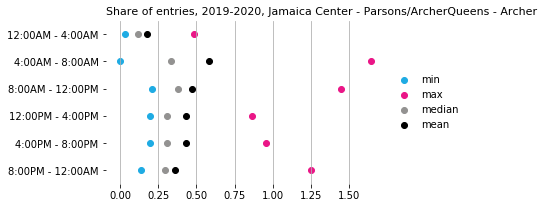

In [17]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2019-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### sutphin blvd - queens blvd

In [18]:
station = 'Sutphin BlvdQueens Blvd'

a19 = df19[df19.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx

entries_share                              
                          min       max    median      mean
timegroupnbr_19                                            
0                    0.032401  0.133136  0.062582  0.070320
1                    0.300844  1.039160  0.332948  0.443590
2                    0.212956  0.558252  0.246233  0.300215
3                    0.199252  0.443464  0.249273  0.274146
4                    0.219856  0.538410  0.247115  0.288106
5                    0.200778  0.534512  0.223010  0.276900

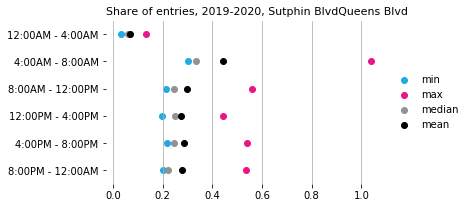

In [19]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2019-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### sutphin blvd - archer av - jfk - archer

In [20]:
station = 'Sutphin Blvd - Archer Av - JFK AirportQueens - Archer'

a19 = df19[df19.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx

entries_share                              
                          min       max    median      mean
timegroupnbr_19                                            
0                    0.109541  0.482759  0.356472  0.338874
1                    0.000000  0.339623  0.188978  0.167646
2                    0.209898  1.442667  0.375199  0.532696
3                    0.230189  0.515564  0.293198  0.318211
4                    0.197492  0.478411  0.286314  0.298982
5                    0.137134  0.776699  0.297710  0.339277

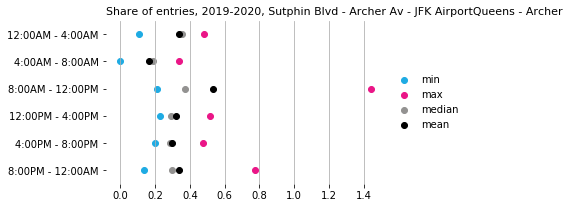

In [21]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2019-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

### jamaica center

In [22]:
station = 'Jamaica Center - Parsons/ArcherQueens - Archer'

a19 = df19[df19.station_id.eq(station)].copy().reset_index(drop=True)
a20 = df20[df20.station_id.eq(station)].copy().reset_index(drop=True)

a19.columns = [c + '_19' for c in a19.columns]
a20.columns = [c + '_20' for c in a20.columns]

achg = pd.concat([a19, a20], axis=1)

assert np.all(achg.timegroupnbr_20.eq(achg.timegroupnbr_20))
assert np.any(achg.entries_diff_20.notna()) & np.any(achg.entries_diff_19.notna())

achg['entries_share'] = achg.entries_diff_20 / achg.entries_diff_19

agg = ['min', 'max', 'median', 'mean']
xx = achg.groupby('timegroupnbr_19').agg({'entries_share':agg})

xx

entries_share                              
                          min       max    median      mean
timegroupnbr_19                                            
0                    0.057644  0.215768  0.103740  0.121820
1                    0.528960  1.644096  1.154156  1.141481
2                    0.349691  0.830538  0.575903  0.583101
3                    0.343509  0.860177  0.685519  0.695577
4                    0.357673  0.955378  0.789124  0.716196
5                    0.194660  1.247039  0.343062  0.464189

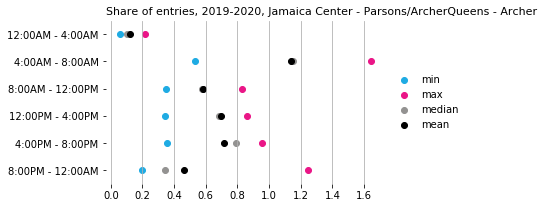

In [23]:
fig, ax = plt.subplots(figsize=(5,.5*len(xx)))

colors = ['#1fabe3', '#ea1687', '#939291', 'k']

for col, c, l in zip(xx, colors, agg):
    x = xx[col].values
    plt.scatter(x, xx.index, color=c, label=l)
    
decorate('', '')
plt.title(f'Share of entries, 2019-2020, {station}', loc='left', fontsize=11)

plt.grid(axis='x')
plt.ylim(5.5, -0.5)
plt.yticks(ticks=np.arange(6), labels=['12:00AM - 4:00AM', '4:00AM - 8:00AM', '8:00AM - 12:00PM',
                   '12:00PM - 4:00PM', '4:00PM - 8:00PM', '8:00PM - 12:00AM'])

plt.show();

## takeaways

The data suggest three major takeaways:
1. Overall ridership across the three stations is way down, at **about 56% of 2019's ridership.**
    1. 31% at Jamaica Center
    2. 72% at Sutphin Blvd / Queens Blvd.
    3. 68% at Sutphin Blvd / Archer Ave
    
    
2. In the two week period of study in 2020, the **overall trend in ridership is flat at all three stations** with no signs of a recent increase.


3. While overall ridership is down, **ridership during the early morning peak (4AM - 8AM) has decreased less, about 42% on average compared to an overall decline of 56%.** One hypothesis for this is that ridership among essential workers (who might need to get up early) is robust.
    1. At Jamaica Center, ridership between 4AM and 8AM is up about 15% compared to 2019, compared to the overall decline of 31%.
    2. At Sutphin Blvd / Queens Blvd, ridership between 4AM and 8AM is down about 55% compared to 2019, compared to 72% overall.
    3. This trend does not appear to be true at Sutphin Blvd / Archer Ave / JFK, however, where ridership between 4AM and 8AM is down 82% compared to 68% overall.